In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
from numpy.random import default_rng
rng = default_rng()

In [2]:
def monte_carlo(sample, proba = 0.95):
    mean = np.mean(sample)
    var = np.var(sample, ddof=1)
    alpha = 1 - proba
    quantile = stats.norm.ppf(1 - alpha/2)  # fonction quantile
    ci_size = quantile * np.sqrt(var / sample.size)
    result = { 'mean': mean, 'var': var,
               'lower': mean - ci_size,
               'upper': mean + ci_size }
    return result

# Pricing Black-Scholes, Call 1d

In [3]:
r = 0.1
sigma = 0.25
S0 = 100.
K = 100.
N, T = 10, 1

batch_size = 64
M = 1000

## Formule fermée du prix $P$ et du $\delta = \frac{\partial P}{\partial x}$

In [4]:
from scipy.stats import norm

def d1(spot, t, r=r, sigma=sigma, strike=K):
    return (np.log(spot / strike) + t * (r + 0.5*sigma**2)) / (sigma * np.sqrt(t))

def d2(spot, t, r=r, sigma=sigma, strike=K):
    return d1(spot, t, r, sigma, strike) - sigma * np.sqrt(t)

def price_call_BS(spot, t, r=r, sigma=sigma, strike=K):
    d1_ = d1(spot, t, r, sigma, strike)
    d2_ = d2(spot, t, r, sigma, strike)
    return spot * norm.cdf(d1_) - strike * np.exp(-r * t) * norm.cdf(d2_)

def dprice_call_BS(spot, t, r=r, sigma=sigma, strike=K):
    return norm.cdf(d1(spot, t, r, sigma, strike))

In [5]:
price_call_BS(S0, T, r, sigma, K)

14.9757907783113

In [6]:
dprice_call_BS(S0, T, r, sigma, K)

0.7002084045313042

In [7]:
from jax import grad
import jax.numpy as jnp

In [8]:
def simu_BS1d(x0, sample_size):
    brown_acc = jnp.sqrt(T)*rng.standard_normal(size=(sample_size))
    return x0 * jnp.exp((r - 0.5 * sigma**2)*T + sigma*brown_acc)

In [9]:
def payoff_call(x):
    return jnp.exp(-r*T) * jnp.maximum(x-K, 0)

In [10]:
def payoff_sample(x0, sample_size):
    sample = simu_BS1d(x0, int(1e5))
    return payoff_call(sample)

In [11]:
#M = int(1e5)
monte_carlo(np.array(payoff_sample(S0, sample_size=M)))

{'mean': 14.960833,
 'var': 393.85046,
 'lower': 14.837830143066842,
 'upper': 15.083835048583548}

In [12]:
def price_monte_carlo(x):
    return payoff_sample(x, sample_size=M).mean()

In [13]:
grad(price_monte_carlo)(S0)

Array(0.70156103, dtype=float32, weak_type=True)

## Without hedging

For the hedging , we consider the dates $t_n = n \frac{T}{N}$, $n=0,\dots,N$ with $N \in \{10, 100, 1000\}$.

In [14]:
def simu_S(N, M):
    h = T/N
    brown_acc = np.sqrt(h)*rng.standard_normal(size=(N, M))
    sample = np.zeros(shape=(N+1, M))
    sample[0] = S0
    for n in range(1, N+1):
        sample[n] = sample[n-1] * np.exp((r - 0.5 * sigma**2)*h + sigma*brown_acc[n-1])
    return sample

In [15]:
N, M = 10, int(1e6)
sample = simu_S(N, M)
print(sample.shape)
sample_act = np.exp(-r * np.arange(N+1) * T/N)[:,None] * sample

(11, 1000000)


In [16]:
monte_carlo(np.exp(-r*T)*np.maximum(sample[N]-K, 0))

{'mean': 14.965534463603621,
 'var': 395.28563717973503,
 'lower': 14.926566868121762,
 'upper': 15.00450205908548}

In [17]:
P0m = np.exp(-r*T)*np.maximum(sample[N]-K, 0).mean()
print("Price Monte Carlo:", P0m)

Prix Monte Carlo: 14.96553446360363


In [19]:
P0e = price_call_BS(S0, T, r, sigma, K)
print("Price exact:", P0e)

Price exact: 14.9757907783113


In [20]:
value0 = P0e - np.exp(-r*T)*np.maximum(sample[N]-K, 0)
monte_carlo(value0)

{'mean': 0.010256314707674921,
 'var': 395.28563717973503,
 'lower': -0.028711280774183986,
 'upper': 0.04922391018953383}

In [21]:
(value0 > 0).mean()

0.631332

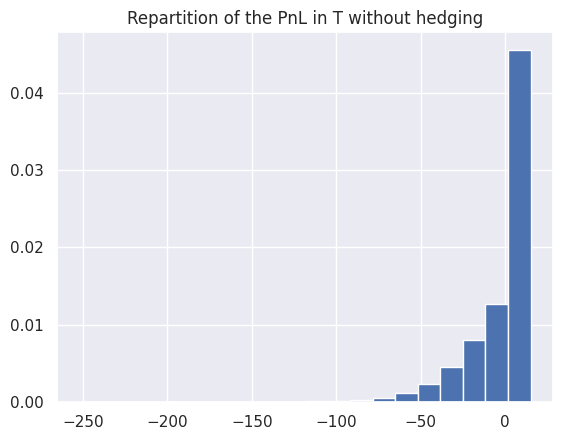

In [22]:
fig, ax = plt.subplots()
ax.hist(value0, bins=20, density=True)
ax.set_title("Repartition of the PnL in T without hedging")
plt.show()

## Delta Hedging

In [24]:
delta = np.zeros_like(sample)
for n in range(N):
    delta[n] = dprice_call_BS(sample[n], (N-n)*T/N)

In [25]:
value = np.zeros_like(sample)
value[0] = P0e - delta[0] * sample_act[0]
for n in range(1,N):
    value[n] = value[n-1] - (delta[n] - delta[n-1]) * sample_act[n]
value[N] = value[N-1] + delta[N-1] * sample_act[N] - np.exp(-r*T)*np.maximum(sample[N]-K, 0)

In [26]:
monte_carlo(value[N])

{'mean': 0.002936516806502008,
 'var': 5.415061881571848,
 'lower': -0.0016243753463085256,
 'upper': 0.007497408959312541}

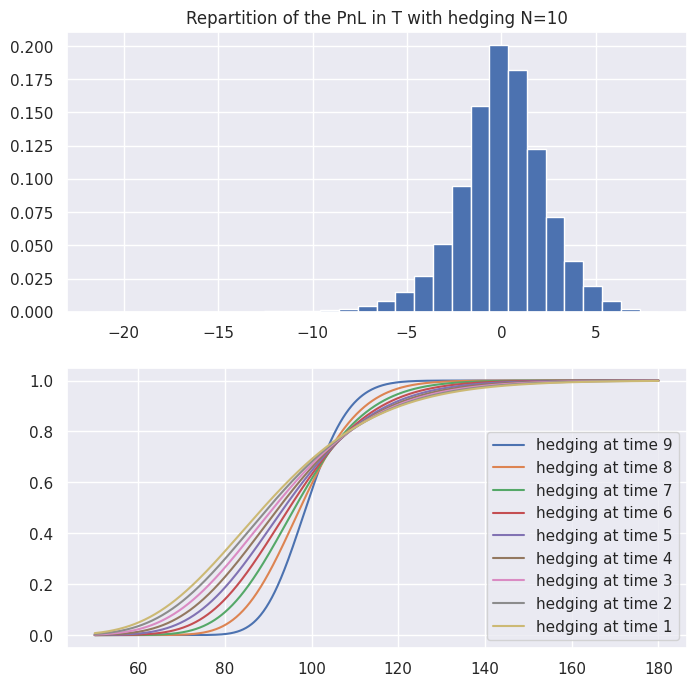

In [27]:
xx = np.linspace(50, 180, 1000)
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(8,8))
ax1.hist(value[N], bins=30, density=True)
ax1.set_title(f"Repartition of the PnL in T with hedging N={N}")
for n in reversed(range(1, N)):
    ax2.plot(xx, dprice_call_BS(xx, (N-n)*T/N), label=f"hedging at time {n}")
ax2.legend()
plt.show()

In [28]:
(value[N] > 0).mean()

0.514702

#Use of NN for hedging strategy

In the framework of an European Call BS 1d, we are going to compute a hedging strategy in optimale quadratic mean obtained by a NN.

In [35]:
!pip install torch torchvision

In [36]:
import torch
import torch.nn as nn

In [37]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
        )

    def forward(self, x):
        out = self.linear_relu_stack(x)
        return out

In [38]:
from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset

In [64]:
def hedging_nn(model, S0=100, K=100, T=1, r=0.1, sigma=0.25, N=100, batch_size=32, M=100000):
    dt = T/N
    optimizer = torch.optim.Adam(model.parameters())

    for i in tqdm(range(int(M/batch_size))):
        S = simu_S(N, batch_size).T
        dS = torch.tensor(np.diff((S*np.exp(-r * dt * np.arange(N + 1))), axis=1)).float()

        #payoff à la maturité actualisé
        Z = torch.tensor(np.exp(-r * T) * np.maximum(S[:, -1] - K, 0)).float()

        #moyenne = np.mean(S, axis = 0)
        #ecart_type = np.std(S, axis = 0)
        #ecart_type[ecart_type == 0] = 1

        moyenne = S0 * np.exp(r * np.arange(N + 1) * dt)
        ecart_type = S0 * np.exp(r * np.arange(N + 1) * dt) * (np.exp(sigma ** 2 * np.arange(N + 1) * dt) - 1)
        ecart_type[0] = 1


        S = (S - moyenne) / ecart_type

        time = (T - dt * np.arange(N))
        time = time / T

        repeated_time = np.tile(time.reshape((1, -1)), (batch_size, 1))
        stacked_data = np.concatenate([S[:, :-1, np.newaxis], repeated_time[:, :, np.newaxis]], axis=2)
        stacked_data = torch.tensor(stacked_data).float()


        output = model(stacked_data)

        hedging = (output.view((batch_size, N)) * dS).sum(axis=1)
        P0 = price_call_BS(S0,T, r, sigma,K)


        loss = torch.mean((P0 + hedging - Z )**2)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    return model

In [79]:
M = 100000
N = 100

model = NeuralNetwork(2,8,1)
model = hedging_nn(model, S0, K, T, r, sigma, N, batch_size, M)

100%|██████████| 1562/1562 [00:05<00:00, 274.13it/s]


In [60]:
def NN_pnl(model, S, S0, K, T, r, sigma, N):
    dt = T/N
    size = S.shape[0]

    Z = torch.tensor(np.exp(-r*T)*np.maximum(S[:,-1]-K,0)).float()
    dS = np.diff((S*np.exp(-r * dt * np.arange(N + 1))), axis=1)


    #moyenne = np.mean(S, axis = 0)
    #ecart_type = np.std(S, axis = 0)
    #ecart_type[ecart_type == 0] = 1

    moyenne = S0 * np.exp(r * np.arange(N + 1) * dt)
    ecart_type = S0 * np.exp(r * np.arange(N + 1) * dt) * (np.exp(sigma ** 2 * np.arange(N + 1) * dt) - 1)
    ecart_type[0] = 1


    S = (S - moyenne) / ecart_type

    time = (T - dt * np.arange(N))
    time = time / T

    repeated_time = np.tile(time.reshape((1, -1)), (size, 1))
    stacked_data = np.concatenate([S[:, :-1, np.newaxis], repeated_time[:, :, np.newaxis]], axis=2)
    stacked_data = torch.tensor(stacked_data).float()


    with torch.no_grad():

      output = model(stacked_data)

      hedging = (output.view((size, N)) * dS).sum(axis=1)
      P0 = price_call_BS(S0,T, r, sigma, K)
      loss = P0 + hedging - Z

    return loss.numpy(), output


In [88]:
S = simu_S(N, M).T

result_NN = NN_pnl(model, S, S0, K, T, r, sigma, N)
hedge = result_NN[1]

In [85]:
print(len(hedge))

100000


In [91]:
hedge = sorted(result_NN[1].numpy().mean(axis = 0))
#print(result_NN[2])
print(hedge)

[array([0.6436587], dtype=float32), array([0.6447366], dtype=float32), array([0.64565796], dtype=float32), array([0.64689577], dtype=float32), array([0.64789975], dtype=float32), array([0.6487404], dtype=float32), array([0.6498494], dtype=float32), array([0.6509866], dtype=float32), array([0.6517566], dtype=float32), array([0.652698], dtype=float32), array([0.6534769], dtype=float32), array([0.6543], dtype=float32), array([0.6555425], dtype=float32), array([0.656495], dtype=float32), array([0.6571936], dtype=float32), array([0.6578363], dtype=float32), array([0.65864706], dtype=float32), array([0.659817], dtype=float32), array([0.6606206], dtype=float32), array([0.66131914], dtype=float32), array([0.66197556], dtype=float32), array([0.66269565], dtype=float32), array([0.6635519], dtype=float32), array([0.6643024], dtype=float32), array([0.6649707], dtype=float32), array([0.66534173], dtype=float32), array([0.6653539], dtype=float32), array([0.6657007], dtype=float32), array([0.6657629]

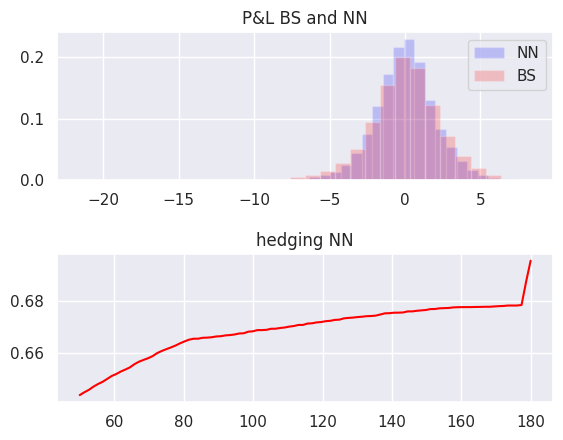

In [92]:
fig, ax = plt.subplots(nrows=2, ncols=1)

ax[0].hist(result_NN[0], bins=30, density=True, alpha = 0.2, color="blue", label = "NN")
ax[0].hist(value[10], bins=30, density=True, alpha = 0.2, color="red", label = "BS")
ax[1].plot(np.linspace(50, 180, N),hedge, color="red")

ax[0].set_title("P&L BS and NN")
ax[1].set_title("hedging NN")
plt.subplots_adjust(hspace=0.5)

ax[0].legend()
plt.show()